### LIST FILES IN DBFS

In [0]:
# List the files in DBFS
dbutils.fs.ls("/FileStore/tables/")

[FileInfo(path='dbfs:/FileStore/tables/Occupancy_Detection_Data-1.csv', name='Occupancy_Detection_Data-1.csv', size=50968, modificationTime=1709140055000),
 FileInfo(path='dbfs:/FileStore/tables/Occupancy_Detection_Data.csv', name='Occupancy_Detection_Data.csv', size=50968, modificationTime=1709139727000),
 FileInfo(path='dbfs:/FileStore/tables/Retailer/', name='Retailer/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/TS021_2021_2.csv', name='TS021_2021_2.csv', size=497239, modificationTime=1710960935000),
 FileInfo(path='dbfs:/FileStore/tables/account-models/', name='account-models/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts/', name='accounts/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=1706725968000),
 FileInfo(path='dbfs:/FileStore/tables/accounts__1_-1.zip', name='accounts__1_-1.zip', size=5297592, modificationTime=1707318536000),
 

###DATA FILES UNZIPPING 

In [0]:
#Copy files to local file system and Unzip
fileroot = "clinicaltrial_2023"

dbutils.fs.cp("/FileStore/tables/"+ fileroot + ".zip", "file:/tmp/")

True

In [0]:
import os
os.environ["fileroot"] = fileroot

In [0]:
%sh
unzip -d /tmp/ /tmp/$fileroot.zip

Archive:  /tmp/clinicaltrial_2023.zip
  inflating: /tmp/clinicaltrial_2023.csv  


In [0]:
%sh
ls /tmp/

Rserv
RtmpZKgc2Z
chauffeur-daemon-params
chauffeur-daemon.pid
chauffeur-env.sh
clinicaltrial_2023.csv
clinicaltrial_2023.zip
custom-spark.conf
driver-daemon-params
driver-daemon.pid
driver-env.sh
hsperfdata_root
python_lsp_logs
systemd-private-d827702f80a84eb495341a46d18094b6-systemd-logind.service-WWSY22
systemd-private-d827702f80a84eb495341a46d18094b6-systemd-resolved.service-D52Q19
tmp.nUiiO0CV9z


### MOVING CSV FILES BACK TO DBFS AND CLEANING OUT ZIP FILES FROM DBFS

In [0]:
# Moving files from local file system back to DBFS
dbutils.fs.mv("file:/tmp/" + fileroot + ".csv", "FileStore/tables/", True)

True

In [0]:
# Removing zipped files from DBFS
dbutils.fs.rm("/FileStore/tables/"+ fileroot + ".zip")

True

### RETRIEVING FIRST FEW ELEMENTS OF THE CSV FILE

In [0]:
dbutils.fs.head("/FileStore/tables/clinicaltrial_2023.csv")

[Truncated to first 65536 bytes]


'"Id\tStudy Title\tAcronym\tStatus\tConditions\tInterventions\tSponsor\tCollaborators\tEnrollment\tFunder Type\tType\tStudy Design\tStart\tCompletion",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,\r\n"NCT03630471\tEffectiveness of a Problem-solving Intervention for Common Adolescent Mental Health Problems in India\tPRIDE\tCOMPLETED\tMental Health Issue (E.G.", Depression, Psychosis, Personality Disorder," Substance Abuse)\tBEHAVIORAL: PRIDE \'Step 1\' problem-solving intervention|BEHAVIORAL: Enhanced usual care\tSangath\tHarvard Medical School (HMS and HSDM)|London School of Hygiene and Tropical Medicine\t250.0\tOTHER\tINTERVENTIONAL\tAllocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (INVESTIGATOR"," OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT\t2018-08-20\t2019-02-28",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

### CONVERTING CLINICAL TRIAL CSV FILE TO RDD

In [0]:
clinicaltrial_2023 = sc.textFile("/FileStore/tables/clinicaltrial_2023.csv")

### DATA CLEANING AND PREPARATION FOR CLINICAL TRIAL 

In [0]:
# Cleaning the RDD, removing of multiple commas between rows, unnecessary quotation marks and split the lines at \t
clinicaltrial_2023 = clinicaltrial_2023.map(lambda line: line.replace('"','').replace(',,','').split("\t"))

# Declare header 
header = clinicaltrial_2023.first()

# Checking if all rows are the same length as the header, adding new column value 'NULL' 
clinicaltrial_2023 = clinicaltrial_2023.map(lambda row: row + ["NULL" for i in range(len(header) - len(row))] if len(row) < len(header) else row)

# Replacing all blank values in each row with 'NULL' 
clinicaltrial_2023 = clinicaltrial_2023.map(lambda row: [col if col != "" else "NULL" for col in row])

clinicaltrial_2023.take(10)

[['Id',
  'Study Title',
  'Acronym',
  'Status',
  'Conditions',
  'Interventions',
  'Sponsor',
  'Collaborators',
  'Enrollment',
  'Funder Type',
  'Type',
  'Study Design',
  'Start',
  'Completion'],
 ['NCT03630471',
  'Effectiveness of a Problem-solving Intervention for Common Adolescent Mental Health Problems in India',
  'PRIDE',
  'COMPLETED',
  'Mental Health Issue (E.G., Depression, Psychosis, Personality Disorder, Substance Abuse)',
  "BEHAVIORAL: PRIDE 'Step 1' problem-solving intervention|BEHAVIORAL: Enhanced usual care",
  'Sangath',
  'Harvard Medical School (HMS and HSDM)|London School of Hygiene and Tropical Medicine',
  '250.0',
  'OTHER',
  'INTERVENTIONAL',
  'Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (INVESTIGATOR, OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT',
  '2018-08-20',
  '2019-02-28,'],
 ['NCT05992571',
  'Oral Ketone Monoester Supplementation and Resting-state Brain Connectivity',
  'NULL',
  'RECRUITING',
  'Cerebrovascular Fu

In [0]:
dbutils.fs.head("/FileStore/tables/pharma.csv")

[Truncated to first 65536 bytes]


'"Company","Parent_Company","Penalty_Amount","Subtraction_From_Penalty","Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting","Penalty_Year","Penalty_Date","Offense_Group","Primary_Offense","Secondary_Offense","Description","Level_of_Government","Action_Type","Agency","Civil/Criminal","Prosecution_Agreement","Court","Case_ID","Private_Litigation_Case_Title","Lawsuit_Resolution","Facility_State","City","Address","Zip","NAICS_Code","NAICS_Translation","HQ_Country_of_Parent","HQ_State_of_Parent","Ownership_Structure","Parent_Company_Stock_Ticker","Major_Industry_of_Parent","Specific_Industry_of_Parent","Info_Source","Notes"\n"Abbott Laboratories","Abbott Laboratories","$5,475,000","$0","$5,475,000","2013","20131227","government-contracting-related offenses","False Claims Act and related","kickbacks and bribery","Abbott Laboratories agreed to $5.475 million to resolve allegations that it violated the False Claims Act by paying kickbacks to induce doctors to implant the company\'s car

### CONVERTING PHARMA CSV FILE TO RDD

In [0]:
Pharma = sc.textFile("/FileStore/tables/pharma.csv")

### DATA CLEANING AND PREPARATION FOR PHARMA

In [0]:
Pharma = Pharma.map(lambda line: line.replace('"','').replace(',','\n').split("\n"))

# Declare header 
header1 = Pharma.first()

# Checking if all rows are the same length as the header, adding new column value 'NULL' 
Pharma = Pharma.map(lambda row: row + ["NULL" for i in range(len(header1) - len(row))] if len(row) < len(header1) else row)

# Replacing all blank values in each row with 'NULL' 
Pharma = Pharma.map(lambda row: [col if col != "" else "NULL" for col in row])

Pharma.take(10)

[['Company',
  'Parent_Company',
  'Penalty_Amount',
  'Subtraction_From_Penalty',
  'Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting',
  'Penalty_Year',
  'Penalty_Date',
  'Offense_Group',
  'Primary_Offense',
  'Secondary_Offense',
  'Description',
  'Level_of_Government',
  'Action_Type',
  'Agency',
  'Civil/Criminal',
  'Prosecution_Agreement',
  'Court',
  'Case_ID',
  'Private_Litigation_Case_Title',
  'Lawsuit_Resolution',
  'Facility_State',
  'City',
  'Address',
  'Zip',
  'NAICS_Code',
  'NAICS_Translation',
  'HQ_Country_of_Parent',
  'HQ_State_of_Parent',
  'Ownership_Structure',
  'Parent_Company_Stock_Ticker',
  'Major_Industry_of_Parent',
  'Specific_Industry_of_Parent',
  'Info_Source',
  'Notes'],
 ['Abbott Laboratories',
  'Abbott Laboratories',
  '$5',
  '475',
  '000',
  '$0',
  '$5',
  '475',
  '000',
  '2013',
  '20131227',
  'government-contracting-related offenses',
  'False Claims Act and related',
  'kickbacks and bribery',
  "Abbott Laboratories 

### DISTINCT COUNT OF STUDIES

In [0]:
# Distinct count of studies

# Filter out the header
clinicaltrial_2023 = clinicaltrial_2023.filter(lambda x: x != header)

# Do a distinct count 
Distinct_Study = clinicaltrial_2023.map(lambda x: x[0]).distinct().count()

print(Distinct_Study)

483422


### TYPE OF STUDIES AND THEIR FREQUENCIES

In [0]:
# Type of studies and frequencies 
Study_Types = clinicaltrial_2023.map(lambda x: (x[10], 1))\
                                .filter(lambda x: x[0] != 'NULL')\
                                   .reduceByKey(lambda a, b: a + b)\
                                       .sortBy(lambda x: x[1], ascending=False)
                                      
Types = Study_Types.collect()
for Study, Count in Types:
    print(f'Type = {Study}, Count = {Count}')        

Type = INTERVENTIONAL, Count = 371382
Type = OBSERVATIONAL, Count = 110221
Type = EXPANDED_ACCESS, Count = 928


### TOP 5 CONDITIONS AND THEIR FREQUENCIES

In [0]:
# Top 5 conditions and their frequencies 
Conditions = clinicaltrial_2023.flatMap(lambda x: x[4].split('|')).map(lambda x: (x,1))\
                                         .filter(lambda x: x[0] != 'NULL')\
                                             .reduceByKey(lambda a, b: a + b) \
                                                 .sortBy(lambda x: x[1], ascending=False) 

Conditions_Count = Conditions.take(5)
for Conditions, Count in Conditions_Count:
    print(f'Condition = {Conditions}, Count = {Count}') 

Condition = Healthy, Count = 9731
Condition = Breast Cancer, Count = 7502
Condition = Obesity, Count = 6549
Condition = Stroke, Count = 4072
Condition = Hypertension, Count = 4020


###TOP 10 MOST COMMON SPONSORS THAT ARE NOT PHARMACEUTICAL COMPANIES

In [0]:
# Top 10 most common sponsors that are not pharmaceutical companies 
Pharma_Company = Pharma.map(lambda x: x[1])
Pharma_Company = Pharma_Company.collect()

Sponsors = clinicaltrial_2023.filter(lambda x: x[6] not in Pharma_Company)\
                                .map(lambda x: (x[6], 1))\
                                    .reduceByKey(lambda a, b: a + b)\
                                        .sortBy(lambda x: x[1], ascending=False)

Sponsors.take(10)

[('National Cancer Institute (NCI)', 3410),
 ('Assiut University', 3335),
 ('Cairo University', 3023),
 ('Assistance Publique - Hôpitaux de Paris', 2951),
 ('Mayo Clinic', 2766),
 ('M.D. Anderson Cancer Center', 2702),
 ('Novartis Pharmaceuticals', 2393),
 ('National Institute of Allergy and Infectious Diseases (NIAID)', 2340),
 ('Massachusetts General Hospital', 2263),
 ('National Taiwan University Hospital', 2181)]

###NUMBER OF STUDIES PER MONTH IN 2023

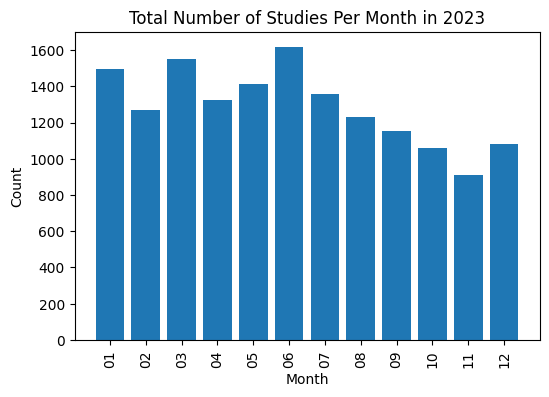

Months = 01, Count = 1494
Months = 02, Count = 1272
Months = 03, Count = 1552
Months = 04, Count = 1324
Months = 05, Count = 1415
Months = 06, Count = 1619
Months = 07, Count = 1360
Months = 08, Count = 1230
Months = 09, Count = 1152
Months = 10, Count = 1058
Months = 11, Count = 909
Months = 12, Count = 1082


In [0]:
# Number of studies per month in 2023 
Completed_Months = clinicaltrial_2023.filter(lambda x: x[3] == 'COMPLETED')\
                        .map(lambda x: x[13][:7])\
                            .map(lambda x: x.split('-'))\
                                .filter(lambda x: x[0] == '2023')\
                                    .map(lambda x: (x[1], 1))\
                                        .reduceByKey(lambda a, b: a + b)\
                                            .sortBy(lambda x: x[0])


Months = Completed_Months.map(lambda x: x[0]).collect()

Count = Completed_Months.map(lambda x: x[1]).collect()

# Import package
import matplotlib.pyplot as plt

# Create the bar plot
plt.figure(figsize=(6, 4))
plt.bar(Months, Count)
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Total Number of Studies Per Month in 2023")
plt.xticks(rotation=90)
plt.show()

Table = Completed_Months.collect()
for Months, Count in Table:
    print(f'Months = {Months}, Count = {Count}') 